# GRPO with Unsloth

**Fine-tune a model with GRPO** (Group Relative Policy Optimization) using **Unsloth**, to improve a model’s reasoning capabilities. We covered GRPO in Chapter 3.

**Unsloth** is a library that accelerates LLM fine-tuning, making it possible to train models faster and with less computational resources. Unsloth is plugs into TRL, so we’ll build on what we learned in the previous sections, and adapt it for Unsloth specifics.

> This exercise can be run on a free Google Colab T4 GPU.

## Install dependencies
First, let’s install the necessary libraries. We’ll need Unsloth for the accelerated fine-tuning and vLLM for fast inference.

In [ ]:
!pip install -qqq unsloth vllm
!pip install -qqq --upgrade pillow

## Setting up Unsloth
Unsloth provides a class (**FastLanguageModel**) that integrates transformers with Unsloth optimizations. Let’s import it:

In [ ]:
from unsloth import FastLanguageModel

Now, let’s load Google’s Gemma 3 1B Instruct model and configure it for fine-tuning:

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 1024  # Can increase for longer reasoning traces
lora_rank = 8  # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="google/gemma-3-1b-it",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # False for LoRA 16bit
    fast_inference=True,  # Enable vLLM fast inference
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.6,  # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Remove QKVO if out of memory
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Enable long context finetuning
    random_state=3407,
)

This code loads the model in **4-bit quantization** to save memory and applies **LoRA (Low-Rank Adaptation)** for efficient fine-tuning. The **target_modules** parameter specifies which layers of the model to fine-tune, and **use_gradient_checkpointing** enables training with longer contexts.

## Data Preparation
For this exercise, we’ll use the **GSM8K** dataset, which contains grade school math problems. We’ll format the data to encourage the model to show its reasoning before providing an answer.

First, we will define the format of the prompts and answers:

In [ ]:
# Define the system prompt that instructs the model to use a specific format
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

Now, let’s prepare the dataset:

In [ ]:
import re
from datasets import load_dataset, Dataset


# Helper functions to extract answers from different formats
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()


def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()


# Function to prepare the GSM8K dataset
def get_gsm8k_questions(split="train") -> Dataset:
    data = load_dataset("openai/gsm8k", "main")[split]
    data = data.map(
        lambda x: {
            "prompt": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": x["question"]},
            ],
            "answer": extract_hash_answer(x["answer"]),
        }
    )
    return data


dataset = get_gsm8k_questions()

In [ ]:
dataset

In [ ]:
dataset = dataset.select(range(700))
dataset

In [ ]:
dataset[0]

The dataset is prepared by extracting the answer from the dataset and formatting it as a string.

## Defining Reward Functions
**GRPO** can use reward functions to guide the model’s learning based on verifiable criteria like length and formatting.

In this exercise, we’ll define several reward functions that encourage different aspects of good reasoning. For example, we’ll reward the model for providing an integer answer, and for following the strict format.

In [ ]:
# Reward function that checks if the answer is correct
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]
    q = prompts[0][-1]["content"]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print(
        "-" * 20,
        f"Question:\n{q}",
        f"\nAnswer:\n{answer[0]}",
        f"\nResponse:\n{responses[0]}",
        f"\nExtracted:\n{extracted_responses[0]}",
    )
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]


# Reward function that checks if the answer is an integer
def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]


# Reward function that checks if the completion follows the strict format
def strict_format_reward_func(completions, **kwargs) -> list[float]:
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]


# Reward function that checks if the completion follows a more relaxed format
def soft_format_reward_func(completions, **kwargs) -> list[float]:
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]


# Reward function that counts XML tags and penalizes extra content
def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1]) * 0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1) * 0.001
    return count


def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

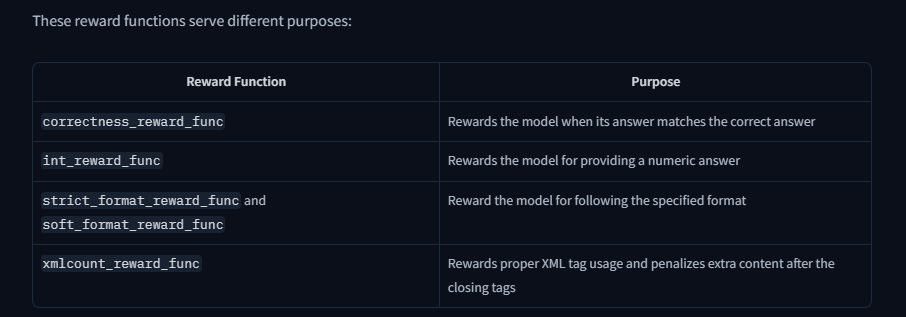

## Training with GRPO
Now we’ll set up the GRPO trainer with our model, tokenizer, and reward functions.

In [ ]:
import wandb

wandb.login()

In [ ]:
from trl import GRPOConfig, GRPOTrainer

max_prompt_length = 256

training_args = GRPOConfig(
    output_dir="GRPO_Unsloth",
    learning_rate=5e-6,
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit",
    logging_steps=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,  # Increase to 4 for smoother training
    num_generations=6,  # Decrease if out of memory
    max_prompt_length=max_prompt_length,
    max_completion_length=max_seq_length - max_prompt_length,
    num_train_epochs = 1, # Set to 1 for a full training run
    max_steps=250,
    save_steps=250,
    max_grad_norm=0.1,
    # report_to="none",  # Can use Weights & Biases
    report_to=["wandb"],
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args=training_args,
    train_dataset=dataset,
)

The GRPOConfig sets various hyperparameters for training:

* **use_vllm**: Enables fast inference with vLLM
* **learning_rate**: Controls how quickly the model learns
* **num_generations**: Number of completions to generate for each prompt
* **max_steps**: Total number of training steps to perform
Now let’s start the training:

In [ ]:
wandb.init(project="GRPO_Unsloth")
trainer.train()

Training may take some time. You might not see rewards increase immediately - it can take 150-200 steps before you start seeing improvements. Be patient!

## Testing the Model
After training, let’s test our model to see how it performs. First, we’ll save the LoRA weights:

In [ ]:
model.save_lora("grpo_saved_lora")

Now, let’s test the model with a new question:

In [ ]:
from vllm import SamplingParams

text = tokenizer.apply_chat_template(
    [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": "Calculate pi."},
    ],
    tokenize=False,
    add_generation_prompt=True,
)

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=1024,
)
output = (
    model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0]
    .outputs[0]
    .text
)

print(output)

You should see that the model now follows the specified format, showing its reasoning before providing an answer.

## Saving the Model
Unsloth provides several options for saving your fine-tuned model, but we’ll focus on the most common.

In [ ]:
# Save to 16-bit precision
model.save_pretrained_merged("model", tokenizer, save_method="merged_16bit")

## Pushing to Hugging Face Hub
We’ll push the model to the Hugging Face Hub using the push_to_hub_merged method. This method allows us to push the model in multiple quantization formats.

In [ ]:
# Push to Hugging Face Hub (requires a token)
model.push_to_hub_merged(
    "your-username/model-name", tokenizer, save_method="merged_16bit", token="your_token"
)
# Push tokenizer explicitly
tokenizer.push_to_hub(
    "your-username/model-name",
    token="your_token"
)

Unsloth also supports saving to GGUF format for use with llama.cpp:

In [ ]:
model.push_to_hub_gguf(
    "your-username/model-name",
    tokenizer,
    quantization_method=["q4_k_m", "q8_0", "q5_k_m"],
    token="your_token",
)

The GGUF files can be used with llama.cpp or UI-based systems like Jan or Open WebUI.

## Conclusion
In this exercise, you’ve learned how to:

* Set up Unsloth for accelerated fine-tuning
* Prepare data for GRPO training
* Define custom reward functions to guide the model’s learning
* Train a model using GRPO
* Test the fine-tuned model
* Save the model in various formats  
GRPO is a powerful technique for aligning language models with specific behaviors, and Unsloth makes it accessible even on limited hardware. By combining multiple reward functions, you can guide the model to follow a specific format while also improving its reasoning capabilities.